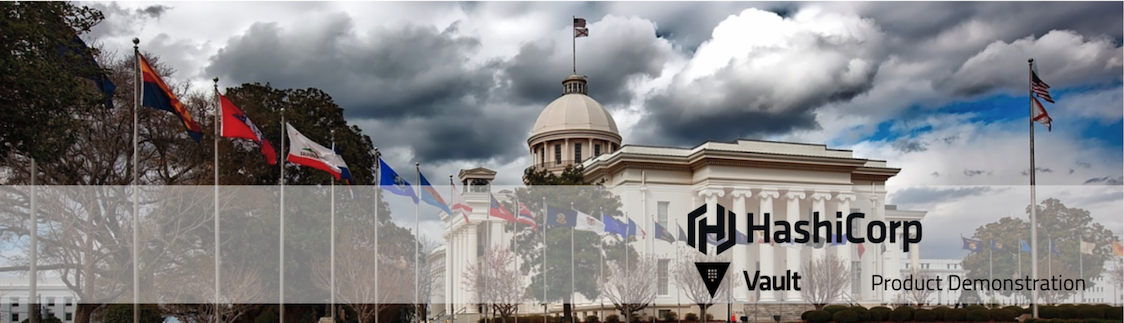

# Vault Agent: Direct Application Integration

Vault Agent is a client-side daemon that can be used to perform some Vault functionality automatically. In this lab we will see how Vault Agent can be run in Docker compose to write templated html files for Nginx with Database and static passwords. This lab is based on Using Vault Agent with Docker compose Medium post - https://medium.com/geekculture/using-vault-agent-with-docker-compose-f410d033026f

**Challenge**
Although a number of auth methods are available, the client is still responsible for managing the lifecycle of its Vault tokens. Therefore, the challenge becomes how to enable authentication to Vault and manage the lifecycle of tokens in a standard way without having to write custom logic.

**Solution**
Vault Agent provides a number of different helper features, specifically addressing the following challenges:
* Automatic authentication
* Secure delivery/storage of tokens
* Lifecycle management of these tokens (renewal & re-authentication)

---

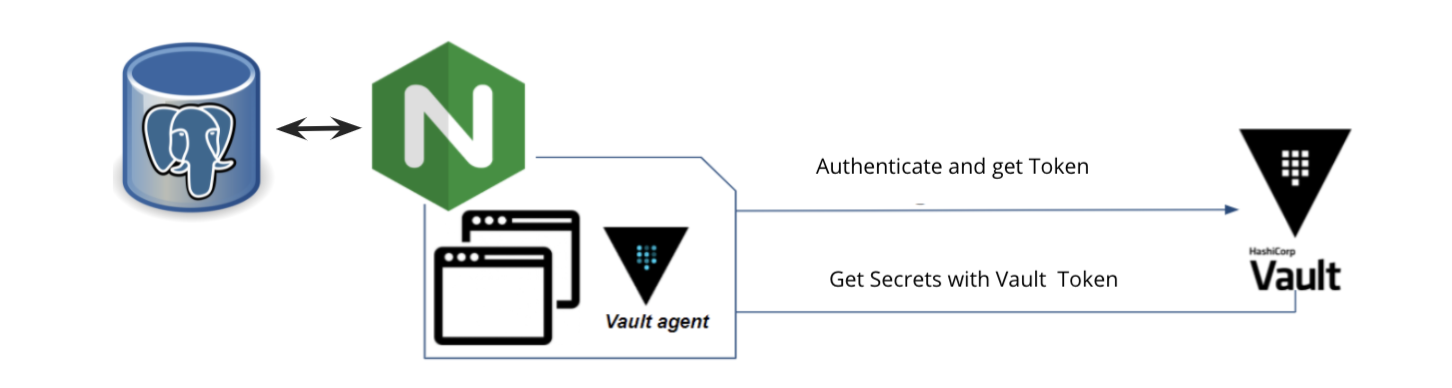

### Prerequisites

* Vault CLI (install vault)
* Docker
* jq

### Workflow

* Step 1: Start the project with Docker Compose - it brings up Vault server (Dev mode), nginx, Vault agent, and Postgres.
* Step 2: Vault: configure policy and Secrets Engines
* Step 3: Vault: configure an authentication method
* Step 4: Docker-compose: Mount a shared volume with the application
* Step 5: Testing Vault Agent Caching
---
# Step 1: Set Up

## Start the project

**Clone Repo in separate terminal and run Docker Compose.**

Vault can now be accessed on http://localhost:8200. The root token for Vault is “root” (without the quotes). The nginx application can be accessed on http://localhost:8080, it will display the default nginx webpage until we perform the configuration steps 1 and 2 as described below..**

Make sure you have vault-agent-docker downloaded to your root directory. By execiting command bellow you shoudl see **vault-agent-docker** in the list.


In [ ]:
cd ~
ls

# Step 2: Vault: configure policy and Secrets Engines

**Create a policy for the nginx application, and configure two Secrets Engines. If you want to take a shortcut, just execute the ./00-secrets.sh script from repository root.**


In [1]:
vault version

Vault v1.7.2+ent (0e2ed0c723715690ce84695805e84e00466909c0)


In [2]:
# Please ensure you are in the repo root directory
# Run ./scripts/00-secrets.sh OR use the commands below

# Setup VAULT_ADDR and VAULT_TOKEN
export VAULT_ADDR=http://127.0.0.1:8200
export VAULT_TOKEN=root
export VAULT_SKIP_VERIFY=true

In [3]:
# Enable the kv Secrets engine and store a secret
vault secrets enable -version=2 kv
vault kv put kv/nginx/static app=nginx username=nginx password=sup4s3cr3t

# Enable the postgres Secrets Engine 
vault secrets enable -path=postgres database
vault write postgres/config/products \
    plugin_name=postgresql-database-plugin \
    allowed_roles="*" \
    connection_url="postgresql://{{username}}:{{password}}@db:5432?sslmode=disable" \
    username="postgres" \
    password="password"
    
# Create a Role for nginx
vault write postgres/roles/nginx \
  db_name=products \
  creation_statements="CREATE ROLE \"{{name}}\" WITH LOGIN PASSWORD '{{password}}' VALID UNTIL '{{expiration}}'; \
  GRANT SELECT ON ALL TABLES IN SCHEMA public TO \"{{name}}\"" \
  default_ttl="30s" \
  max_ttl="24h"

Success! Enabled the kv secrets engine at: kv/
Key              Value
---              -----
created_time     2021-07-14T16:49:33.0573369Z
deletion_time    n/a
destroyed        false
version          1
Success! Enabled the database secrets engine at: postgres/
Success! Data written to: postgres/roles/nginx


In [5]:
# Write a Policy to # List, create, update, and delete key/value secrets
# and Read dynamic database secrets
echo '
path "kv/data/nginx/*"
{
  capabilities = ["create", "read", "update", "delete", "list"]
}

path "postgres/creds/nginx"
{
  capabilities = ["read"]
} ' | vault policy write nginx -


Success! Uploaded policy: nginx


<br></br>
**If the above setup was successful, you should be able to read both static and dynamic secrets as shown below.**

**Create a token with db_creds policy attached.**

In [6]:
# Test reading a static secret
vault kv get kv/nginx/static

====== Metadata ======
Key              Value
---              -----
created_time     2021-07-14T16:49:33.0573369Z
deletion_time    n/a
destroyed        false
version          1

====== Data ======
Key         Value
---         -----
app         nginx
password    sup4s3cr3t
username    nginx


In [7]:
# Test reading a dynamic secrets Database secret
vault read postgres/creds/nginx


Key                Value
---                -----
lease_id           postgres/creds/nginx/4pTyn2FKjv7UJQ0rOT67zV0X
lease_duration     30s
lease_renewable    true
password           DRIRo-pgF3hkqfEJ8xgJ
username           v-token-nginx-CWmZAWmQIUhi8CAvsBLz-1626281508


# Step 3: Vault: configure an authentication method


Run the following commands below to setup AppRole Auth method. 

It will mount the Auth Method, create a Role for the nginx application, then export the Role ID and Secret ID for nginx to use.

For shortcut, just execute the ./02-approle.sh script from repository root.



In [8]:
# Enable AppRole and create a role:
vault auth enable approle
vault write auth/approle/role/nginx token_policies="nginx"

# Write out a Role ID and Secret ID
vault read -format=json auth/approle/role/nginx/role-id \
  | jq -r '.data.role_id' > ~/vault-agent-docker/vault-agent/nginx-role_id
vault write -format=json -f auth/approle/role/nginx/secret-id \
  | jq -r '.data.secret_id' > ~/vault-agent-docker/vault-agent/nginx-secret_id
  
# Restart the vault-agent-demo container
docker restart vault-agent-demo

Success! Enabled approle auth method at: approle/
Success! Data written to: auth/approle/role/nginx
vault-agent-demo


<br><br>
### Result

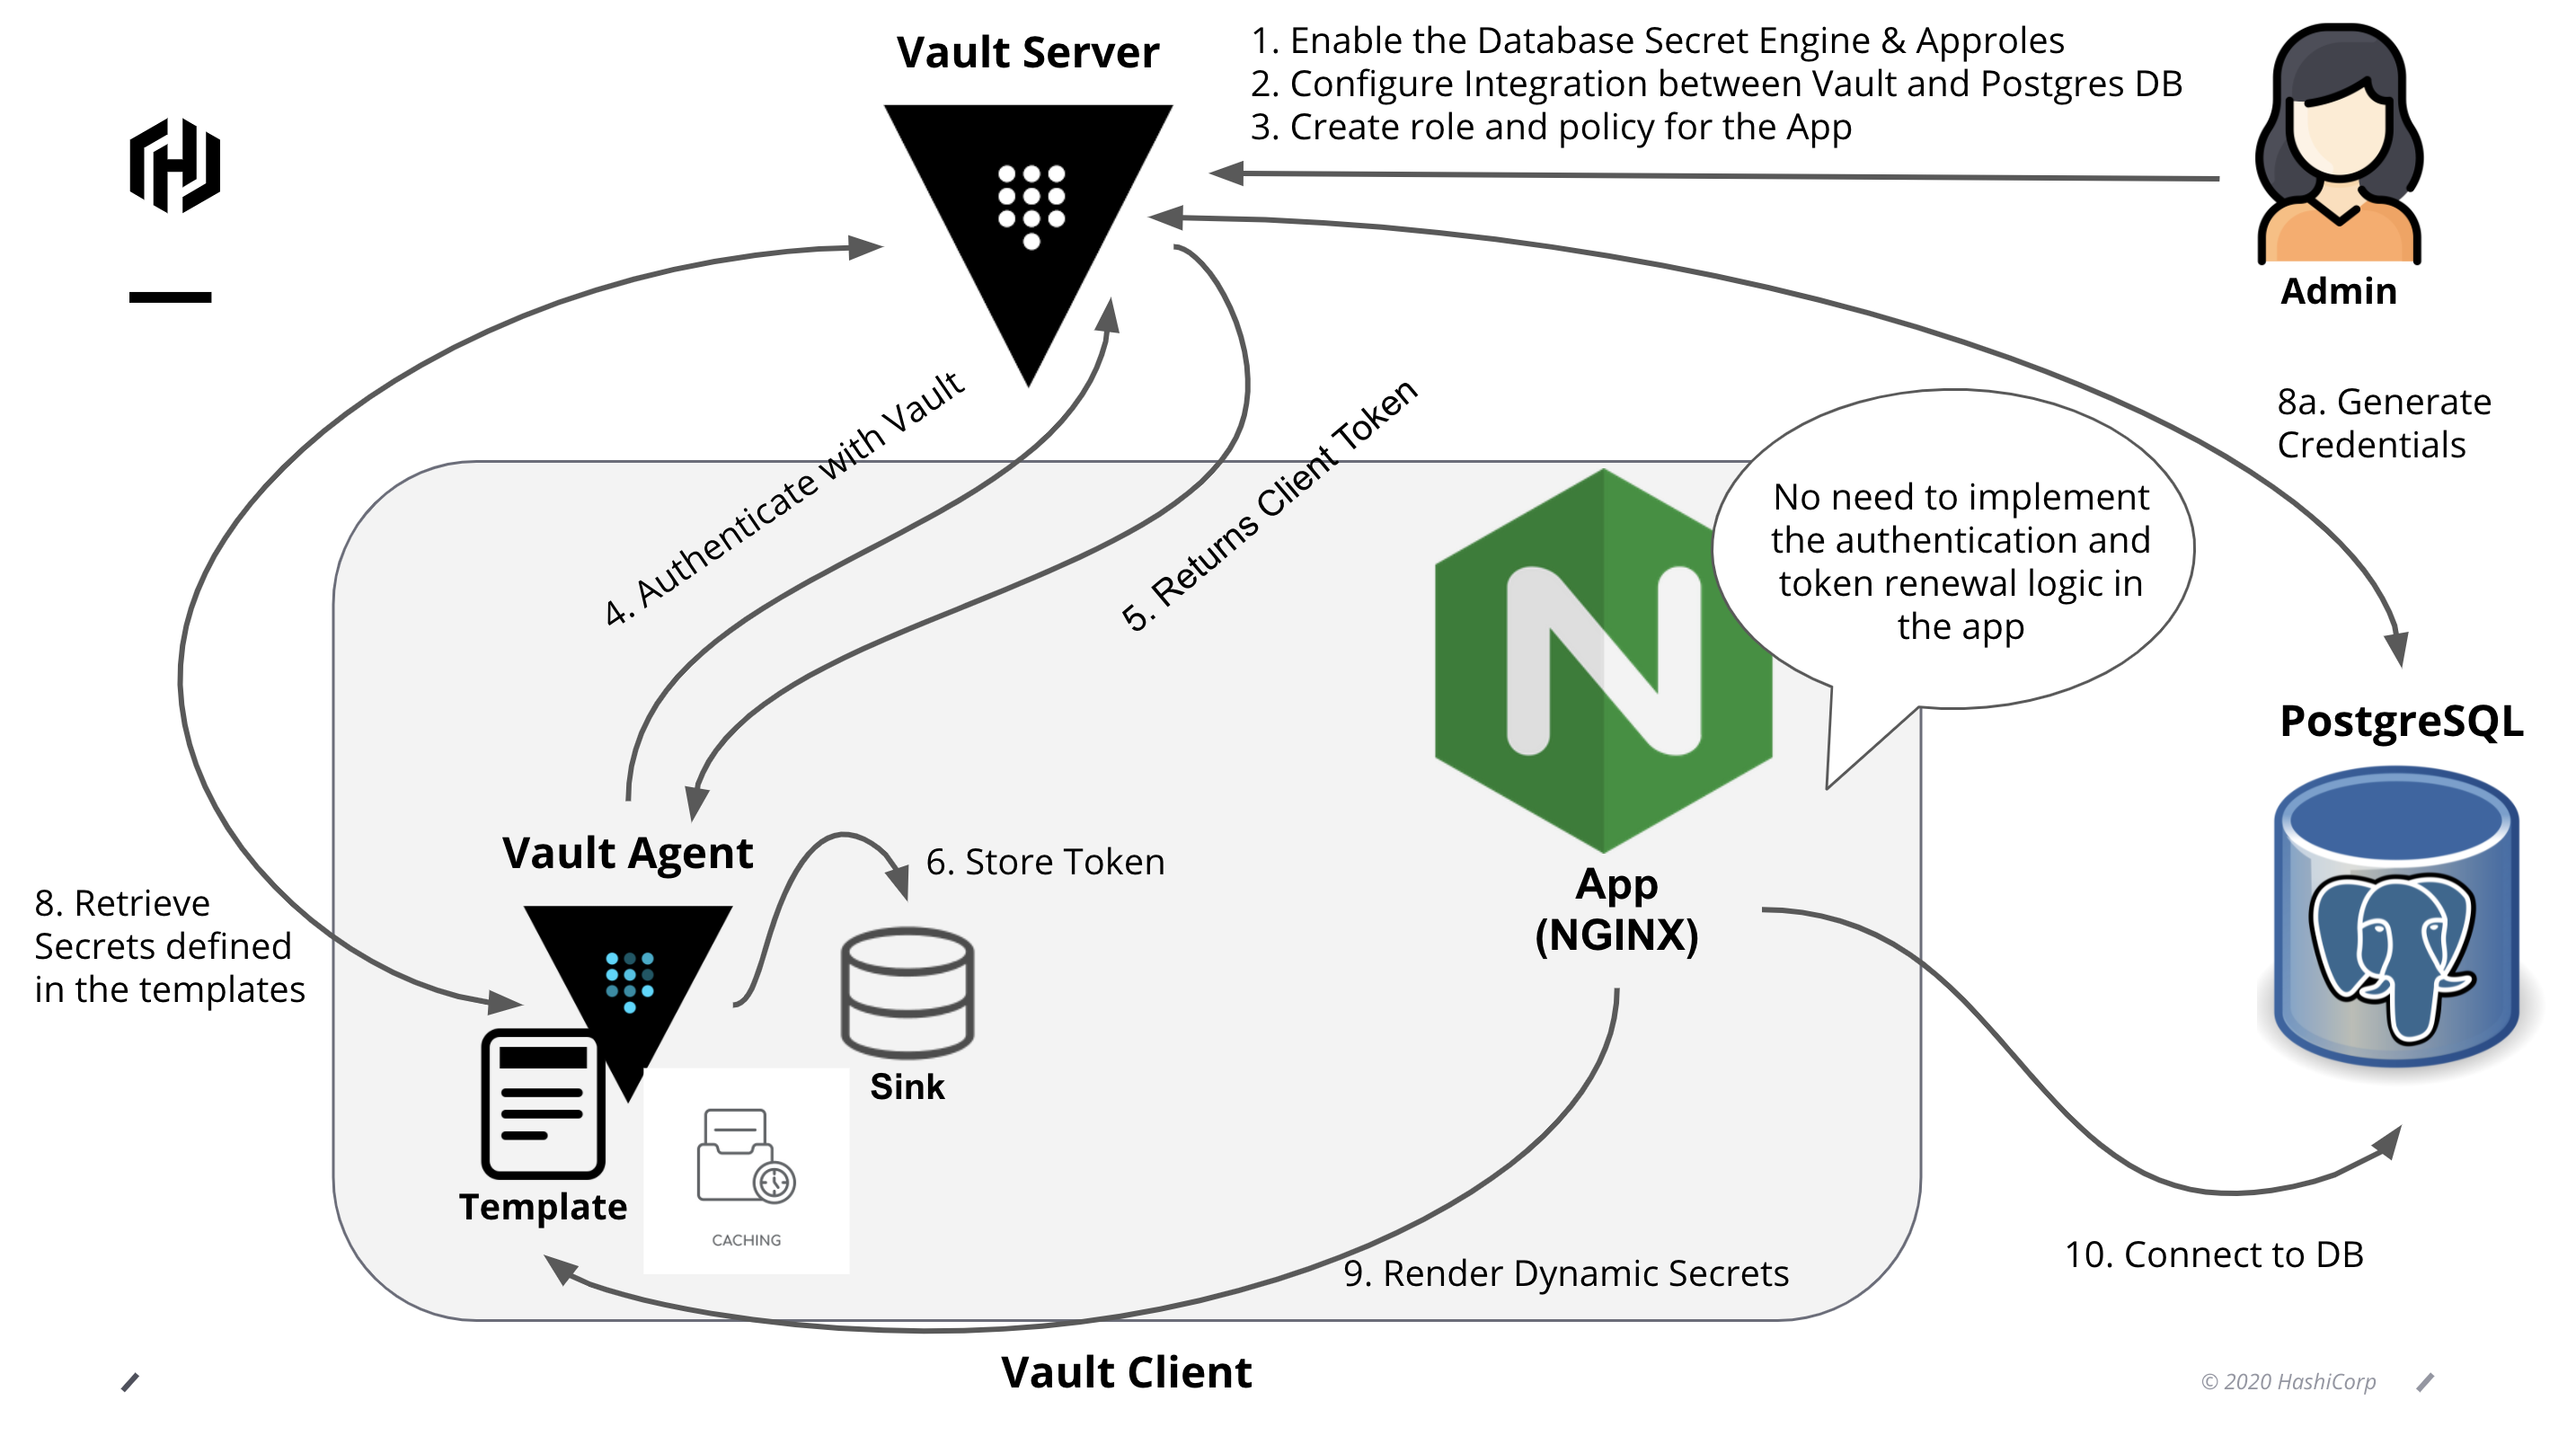

<br></br>

Access http://localhost:8080 on your browser, and you should be able to see the nginx application display a dynamic Postgres database credential provided by Vault as shown below. Also try accessing http://localhost:8080/kv.html to see example static secret values.

**Example dynamic credential read**

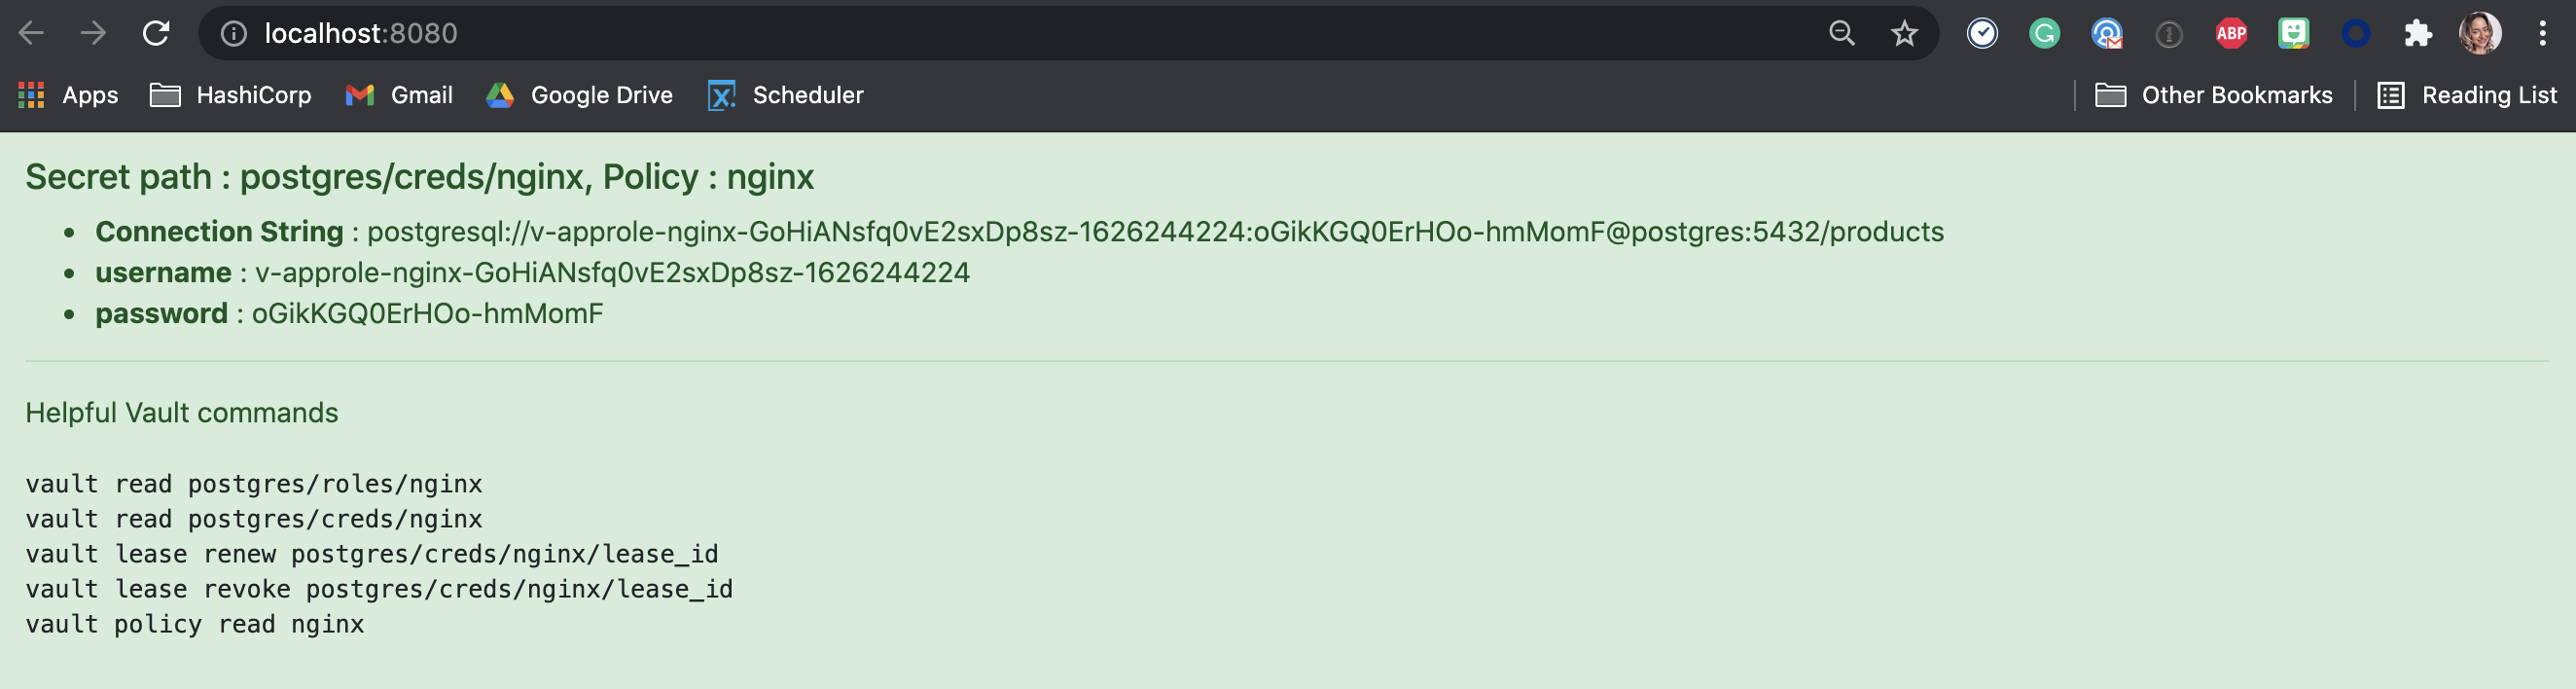

**Example static credential read**

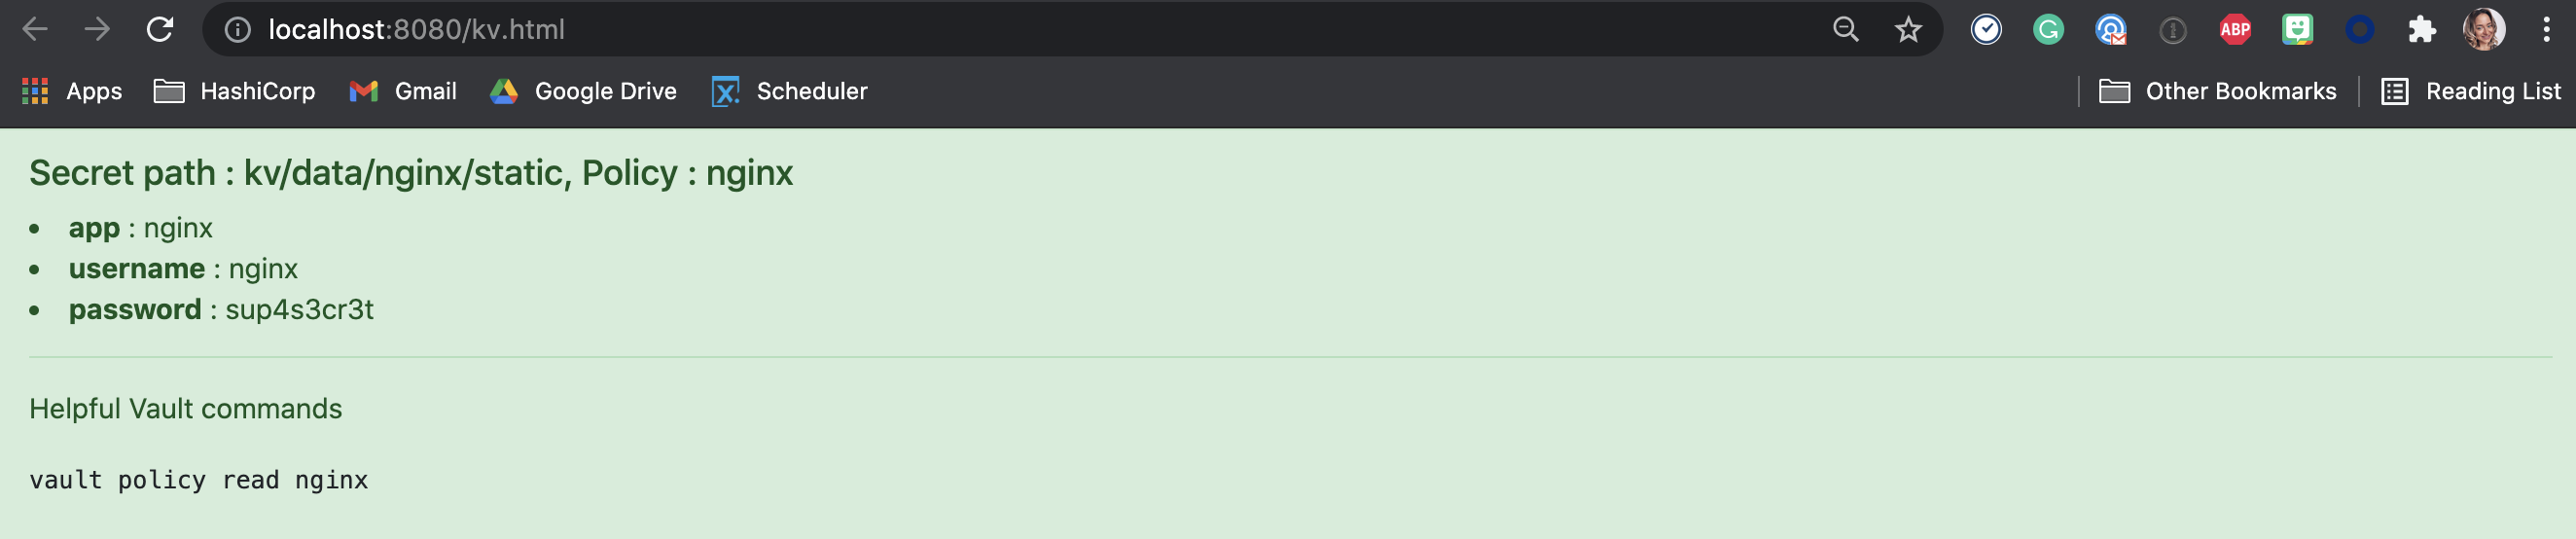

## Explanation: Vault-agent: Write the configuration file


In this case we have already written an example Vault agent configuration file for your review: vault-agent/nginx-vault-agent.hcl file. It specifies how to authenticate the nginx container using AppRole in the auto-auth stanza:


It also includes two template stanzas that tell Vault Agent how to render the secrets in an application friendly way.

Per the template stanzas above, HTML files will be rendered in the /usr/share/nginx/html directory and served by the nginx web server.

# Step 4: Docker-compose: Mount a shared volume with the application

Shared volumes with Docker-compose allow us to ensure that the vault-agent can render secrets in a common directory that can be accessed by the application. For this demo, the local directory ./nginx is mounted for both vault-agent and nginx as shown below

Below is a diagram showing the full workflow. Any updates published in the shared directory is immediately picked up by nginx.


**Workflow for Vault agent**

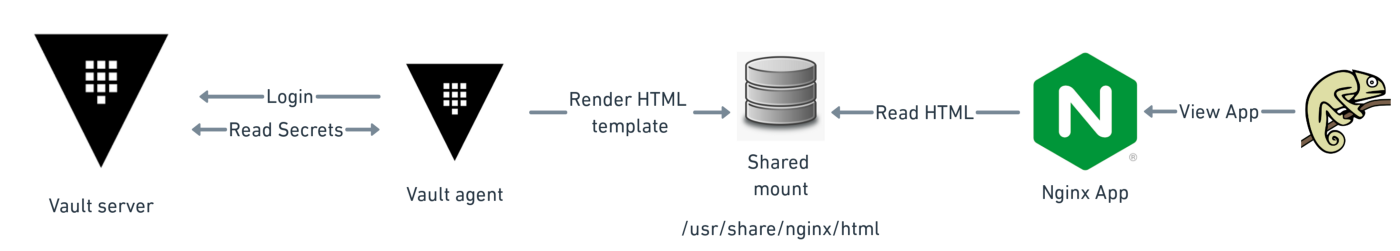

# Step 5:Testing Vault Agent Caching


Vault agent can also provide a local proxy and caching function for an application. The nginx-vault-agent.hcl file includes a listener and a cache block that enables this functionality. The listener is started on port 8200 which is mapped to localhost port 18200 in the docker compose file. In another terminal, issue the following commands to test Vault Agent caching behavior.

In [9]:
unset VAULT_TOKEN
export VAULT_ADDR=http://localhost:18200

vault kv get kv/nginx/static
vault read postgres/creds/nginx
# Run the command a few times
vault read postgres/creds/nginx
vault read postgres/creds/nginx

====== Metadata ======
Key              Value
---              -----
created_time     2021-07-14T16:49:33.0573369Z
deletion_time    n/a
destroyed        false
version          1

====== Data ======
Key         Value
---         -----
app         nginx
password    sup4s3cr3t
username    nginx
Key                Value
---                -----
lease_id           postgres/creds/nginx/E4xTOE9KVyIuFn5erPtu2pNM
lease_duration     30s
lease_renewable    true
password           U9a7WZFKO5k7-u0b2xrp
username           v-approle-nginx-ItymUlLSfuojNMH6Kvta-1626281773
Key                Value
---                -----
lease_id           postgres/creds/nginx/E4xTOE9KVyIuFn5erPtu2pNM
lease_duration     30s
lease_renewable    true
password           U9a7WZFKO5k7-u0b2xrp
username           v-approle-nginx-ItymUlLSfuojNMH6Kvta-1626281773
Key                Value
---                -----
lease_id           postgres/creds/nginx/E4xTOE9KVyIuFn5erPtu2pNM
lease_duration     30s
lease_renewable    true
passwor

In [10]:
echo $VAULT_TOKEN

<br><br>
### There are a few interesting items to highlight:

* **Authentication**: We did not need to set the VAULT_TOKEN environment variable because we specified use_auto_auth_token = true in the nginx-vault-agent.hcl file.
* **Cache**: Vault agent keeps the Database lease renewed. So if you re-run vault read postgres/creds/nginx , Vault agent will keep returning the same credentials until the max TTL is reached, or if the cache is explicitly cleared. Issue docker logs vault-agent-demo to see renewal and cache response entries:

## **Cleanup**

To cleanup, run the ./scripts/cleanup.sh script, or use the commands below.

In [11]:
# Please ensure you are in the repo root directory
# Run ./scripts/cleanup.sh OR use the commands below

docker-compose down
rm -f ./vault-agent/*role_id
rm -f ./vault-agent/*secret_id
rm -f ./vault-agent/token
rm -f ./nginx/index.html
rm -f ./nginx/kv.html

ERROR: 
        Can't find a suitable configuration file in this directory or any
        parent. Are you in the right directory?

        Supported filenames: docker-compose.yml, docker-compose.yaml
        


**END**